In [1]:
# !pip install -r requirements.txt
!pip install keras-self-attention

  Preparing metadata (setup.py) ... done
  Created wheel for keras-self-attention: filename=keras_self_attention-0.51.0-py3-none-any.whl size=18895 sha256=ea9c23cf9324f51673d7cb91914a90754dbb7d787d35c41f43af33b1760b2603
  Stored in directory: /root/.cache/pip/wheels/b8/f7/24/607b483144fb9c47b4ba2c5fba6b68e54aeee2d5bf6c05302e
Successfully built keras-self-attention


# 0. 라이브러리

# 1. Load Data

In [2]:
import pandas as pd
import numpy as np
import os

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from keras_self_attention import SeqSelfAttention
from sklearn.preprocessing import MinMaxScaler
from keras.utils.vis_utils import plot_model

from sklearn.metrics import mean_absolute_error, mean_squared_error

import pickle
import random

In [ ]:
# from tensorflow.python.client import device_lib
# tf.config.list_physical_devices('GPU')

In [3]:

seed_num = 42
tf.random.set_seed(seed_num)
np.random.seed(seed_num)
random.seed(seed_num)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# data load
with open('/content/drive/MyDrive/00.multi_emtions/03.models/movies_train.pkl', 'rb') as f:
    train_set = pickle.load(f)
with open('/content/drive/MyDrive/00.multi_emtions/03.models/movies_test.pkl', 'rb') as f:
    test_set = pickle.load(f)
with open('/content/drive/MyDrive/00.multi_emtions/03.models/movies_validation.pkl', 'rb') as f:
    valid_set = pickle.load(f)


In [ ]:
overall = train_set.shape[0] + valid_set.shape[0] + test_set.shape[0]
print('train:validation:test = %.4f:%.4f:%.4f'%((train_set.shape[0] / overall), (valid_set.shape[0] / overall), (test_set.shape[0] / overall)))

train:validation:test = 0.7000:0.1000:0.2000


In [ ]:
def norm(x):
    _max = x.max()
    _min = x.min()
    _denom = _max - _min
    return (x - _min) / _denom

train_set['rating'] = norm(train_set['rating'])
valid_set['rating'] = norm(valid_set['rating'])

# compound도 0~1로 normalize
train_set['compound'] = norm(train_set['compound'])
valid_set['compound'] = norm(valid_set['compound'])

In [ ]:
# weighted sentiment(negative, positive)
def weighted_pos(compound, pos):
     pos = compound * pos
     return pos

def weighted_neg(compound, neg):
     neg = (1-compound) * neg
     return neg

In [ ]:
train_set['positive'] = weighted_pos(train_set['compound'],train_set['positive'])
valid_set['positive'] = weighted_pos(valid_set['compound'],valid_set['positive'])

train_set['negative'] = weighted_neg(train_set['compound'],train_set['negative'])
valid_set['negative'] = weighted_neg(valid_set['compound'],valid_set['negative'])

# 3.Model

In [6]:
def conv_block(n_layers, latent_dims, names):
    ModuleList, DropoutList = [], []
    for i, _ in enumerate(range(n_layers)):
        ModuleList.append(Dense(latent_dims, activation='relu', name=f'{names}{i+1}'))
        latent_dims //= 2
    return ModuleList

In [ ]:
def ModelBuild(user_num, item_num, id_dims, total_layer_dims, total_n_layer):
    seed_num = 42
    tf.random.set_seed(seed_num)
    np.random.seed(seed_num)
    random.seed(seed_num)
    # user
    user_input = Input(shape=(1,), dtype='int32', name='UserInput')
    user_embedding = Embedding(user_num, id_dims, input_length=user_input.shape[1], name='UserIDEmb')(user_input)
    user_embedding = Flatten(name='UserFlatten')(user_embedding)

    # item
    item_input = Input(shape=(1,), dtype='int32', name='ItemInput')
    item_embedding = Embedding(item_num, id_dims, input_length=item_input.shape[1], name='ItemIDEmb')(item_input)
    item_embedding = Flatten(name='ItemFlatten')(item_embedding)


    # GMF
    # GMF = Multiply()([user_embedding, item_embedding])

    # MLP
    MLP_U_I = Concatenate(name='UserItemLayer')([user_embedding, item_embedding])

    for layer in conv_block(total_n_layer, total_layer_dims, 'UserItemMLP'):
        MLP_U_I = layer(MLP_U_I)


    # Sentiment
    pos_input = Input(shape=(1,), dtype='int32', name='PositiveInput')
    pos_dense = Dense(units=1, activation='relu', name='Dense_Positive')(pos_input)

    neg_input = Input(shape=(1,), dtype='int32', name='NegativeInput')
    neg_dense = Dense(units=1, activation='relu', name='Dense_Negative')(neg_input)

    # anticipation_input = Input(shape=(1,), dtype='int32', name='AnticipationInput')
    # anticipation_dense = Dense(units=1, activation='relu', name='Dense_Anticipation')(anticipation_input)

    # disgust_input = Input(shape=(1,), dtype='int32', name='DisgustInput')
    # disgust_dense = Dense(units=1, activation='relu', name='Dense_Disgust')(disgust_input)

    # fear_input = Input(shape=(1,), dtype='int32', name='FearInput')
    # fear_dense = Dense(units=1, activation='relu', name='Dense_Fear')(fear_input)

    # joy_input = Input(shape=(1,), dtype='int32', name='JoyInput')
    # joy_dense = Dense(units=1, activation='relu', name='Dense_Joy')(joy_input)

    # sadness_input = Input(shape=(1,), dtype='int32', name='SadnessInput')
    # sadness_dense = Dense(units=1, activation='relu', name='Dense_Sadness')(sadness_input)

    # surprise_input = Input(shape=(1,), dtype='int32', name='SurpriseInput')
    # surprise_dense = Dense(units=1, activation='relu', name='Dense_Surprise')(surprise_input)

    # trust_input = Input(shape=(1,), dtype='int32', name='TrustInput')
    # trust_dense = Dense(units=1, activation='relu', name='Dense_Trust')(trust_input)

    # Sentiment = Concatenate(name='SentimentLayer')([anger_dense, anticipation_dense, disgust_dense, fear_dense, joy_dense, sadness_dense, surprise_dense, trust_dense])
    # Sentiment concatenation
    MLP_U_I_S = Concatenate(name='UserItemSentimentLayer')([MLP_U_I, pos_dense, neg_dense])

    # Final concatenation
    # MLP_U_I_S = Concatenate(name='FinalLayer')([MLP_U_I, Sentiment])

    for layer in conv_block(total_n_layer, (total_layer_dims//(2**(total_n_layer-1))+8)//2, 'UserItemSentimentMLP'):
        MLP_U_I_S = layer(MLP_U_I_S)

    outputs = Dense(1, activation='sigmoid', name='outputs')(MLP_U_I_S)
    model = Model(inputs=[user_input, item_input, pos_input, neg_input], outputs=outputs)
    return model

In [ ]:
user_num = 281335
item_num = 59044

id_dims = 128# each 32 dims
total_layer_dims = 32 # ex. 128 -> 128 , 64, 32...
total_n_layer = 3 # concat(64) -> 64-32-16

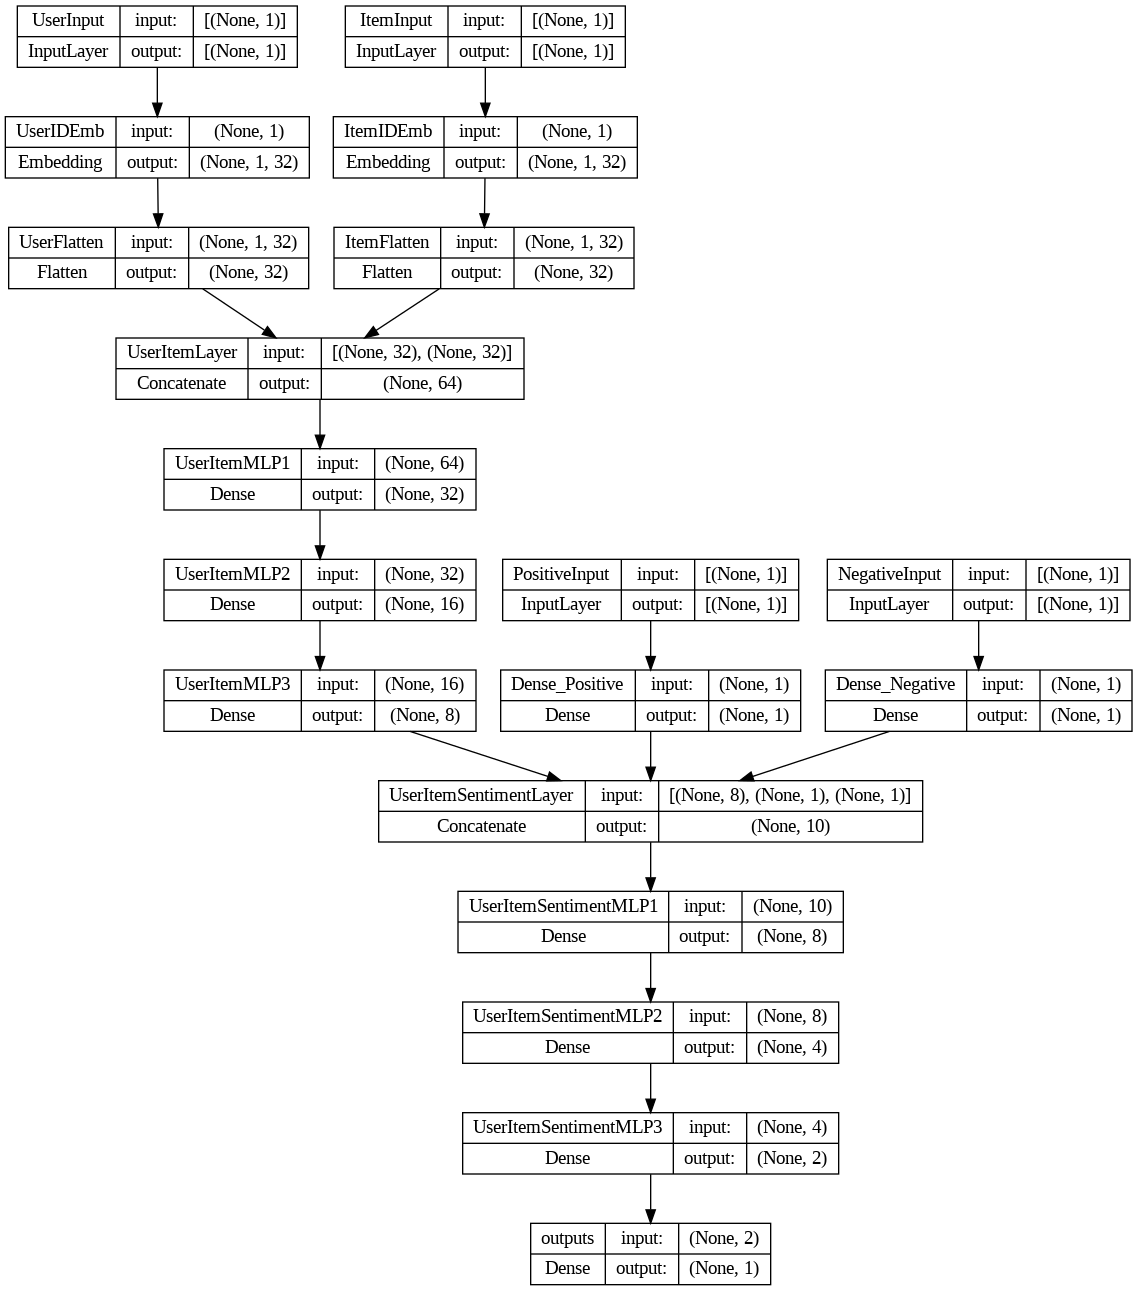

In [ ]:
model = ModelBuild(user_num = 281335, item_num = 59044, id_dims = 32, total_layer_dims = total_layer_dims, total_n_layer = total_n_layer)
plot_model(model, show_shapes=True, show_layer_names=True)

## Jihyeon:모든 파라미터에 대해 돌려보기
- id_dim = [256, 128, 64, 32]
- n layer = 3 고정
- layer_dim = [128, 64, 32, 16]
- lr = [0.0005, 0.0001, 0.005, 0.001]

In [ ]:
def model_run_param(id_dims, total_layer_dims,total_n_layer,lr):

    # param_embedding, param_layer_dim, param_lr = [],[],[]
    # MAE, RMSE = [], []
    seed_num = 42
    tf.random.set_seed(seed_num)
    np.random.seed(seed_num)
    random.seed(seed_num)

    model = ModelBuild(user_num = user_num, item_num = item_num, id_dims = id_dims, total_layer_dims = total_layer_dims, total_n_layer = total_n_layer)

    adam = Adam(learning_rate=lr)
    model.compile(optimizer=adam, loss='binary_crossentropy')
    es = EarlyStopping(monitor='val_loss', mode = 'min', verbose = 1, patience = 3, restore_best_weights = True)
    # model.summary()

    history = model.fit([train_set['userID'], train_set['movieID'], train_set['positive'], train_set['negative'] ],
                train_set['rating'],
                batch_size = 1024,
                epochs = 100,
                callbacks=[es],
                validation_data = ([valid_set['userID'], valid_set['movieID'],valid_set['positive'],valid_set['negative'] ],
                valid_set['rating']))

    prediction = model.predict([test_set['userID'], test_set['movieID'], test_set['positive'], test_set['negative']])

    # normalize 안해도 되겠단 생각이..
    prediction = 4 * norm(prediction) + 1
    # prediction = 4 * prediction + 1

    MAE_temp = mean_absolute_error(test_set['rating'], prediction)
    RMSE_temp = mean_squared_error(test_set['rating'], prediction, squared = False)
    embedding_size = id_dims
    layer_dim = total_layer_dims
    lr = lr
    print(f'embedding:{embedding_size}, layer_dim:{layer_dim},lr:{lr}')
    print(f'MAE: {MAE_temp:.3f}')
    print(f'RMSE: {RMSE_temp:.3f}')

    # MAE.append(MAE_temp)
    # RMSE.append(RMSE_temp)
    # param_embedding.append(embedding_size)
    # param_layer_dim.append(layer_dim)
    # param_lr.append(lr)

    return MAE_temp, RMSE_temp, embedding_size, layer_dim, lr

In [ ]:
# 다시 시도...
user_num = 281335
item_num = 59044

id_dims = [128,64, 32]
total_layer_dims =  [128,64,32] # ex. 128 -> 128 , 64, 32...
total_n_layer = 3 # concat(64) -> 64-32-16
lr = [0.005, 0.001]

In [ ]:
# 다시 시도...
# user_num = 281335
# item_num = 59044

# id_dims = [32]
# total_layer_dims =  [128,64,32] # ex. 128 -> 128 , 64, 32...
# total_n_layer = 3 # concat(64) -> 64-32-16
# lr = [0.005, 0.001]

### 실험1

In [ ]:
MAE, RMSE, param_embedding, param_layer_dim, param_lr = [], [], [], [], []
for a in id_dims:
  for b in total_layer_dims:
    for i in lr:
      MAE_temp, RMSE_temp, embedding_size, layer_dim, learning_rate = model_run_param(a, b,3,i)

      MAE.append(MAE_temp)
      RMSE.append(RMSE_temp)
      param_embedding.append(embedding_size)
      param_layer_dim.append(layer_dim)
      param_lr.append(learning_rate)

Epoch 1/100
2199/2199 [==============================] - 42s 15ms/step - loss: 0.4086 - val_loss: 0.3936
Epoch 2/100
2199/2199 [==============================] - 16s 7ms/step - loss: 0.3590 - val_loss: 0.3926
Epoch 3/100
2199/2199 [==============================] - 16s 7ms/step - loss: 0.3267 - val_loss: 0.4139
Epoch 4/100
2199/2199 [==============================] - 15s 7ms/step - loss: 0.2959 - val_loss: 0.4411
Epoch 5/100
2199/2199 [==============================] - 15s 7ms/step - loss: 0.2722 - val_loss: 0.4759
Epoch 5: early stopping
20099/20099 [==============================] - 32s 2ms/step
embedding:128, layer_dim:128,lr:0.005
MAE: 0.707
RMSE: 1.026
Epoch 1/100
2199/2199 [==============================] - 31s 13ms/step - loss: 0.4093 - val_loss: 0.3907
Epoch 2/100
2199/2199 [==============================] - 15s 7ms/step - loss: 0.3573 - val_loss: 0.3925
Epoch 3/100
2199/2199 [==============================] - 15s 7ms/step - loss: 0.3219 - val_loss: 0.4090
Epoch 4/100
2199/2199

In [ ]:
final_sentiMLP_df = pd.DataFrame(zip(param_embedding, param_layer_dim, param_lr, MAE, RMSE), columns=['embedding size','layer_dim','Learning Rate','MAE','RMSE'])
final_sentiMLP_df

,embedding size,layer_dim,Learning Rate,MAE,RMSE
0,128,128,0.005,0.706567,1.026147
1,128,128,0.001,0.684246,0.949292
2,128,64,0.005,0.705669,1.019147
3,128,64,0.001,0.749192,1.071233
4,128,32,0.005,0.702472,1.013942
5,128,32,0.001,0.730713,1.042662
6,64,128,0.005,0.828490,1.110550
7,64,128,0.001,0.684875,0.950292
8,64,64,0.005,0.697324,1.010933
9,64,64,0.001,0.750987,1.071380


In [ ]:
final_sentiMLP_df.to_csv("/content/drive/MyDrive/00.multi_emtions/02.result/0000.final_NRCsentiMLPresultnorm.csv",index=False)


In [ ]:
sentiMLP_df_norm32 = pd.DataFrame(zip(param_embedding, param_layer_dim, param_lr, MAE, RMSE), columns=['embedding size','layer_dim','Learning Rate','MAE','RMSE'])
sentiMLP_df_norm32

,embedding size,layer_dim,Learning Rate,MAE,RMSE
0,32,128,0.005,0.700410,1.010640
1,32,128,0.001,0.643476,0.942744
2,32,64,0.005,0.687905,1.000299
3,32,64,0.001,0.755535,1.070754
4,32,32,0.005,0.694321,1.009825
5,32,32,0.001,0.751149,1.056218


In [ ]:
sentiMLP_df_norm.to_csv("/content/drive/MyDrive/00.multi_emtions/02.result/000-7.weighted_NRCsentiMLPresultnorm.csv",index=False)

In [ ]:
sentiMLP_df = pd.DataFrame(zip(param_embedding, param_layer_dim, param_lr, MAE, RMSE), columns=['embedding size','layer_dim','Learning Rate','MAE','RMSE'])
sentiMLP_df

,embedding size,layer_dim,Learning Rate,MAE,RMSE
0,256,128,0.005,0.708923,0.957060
1,256,128,0.001,0.677828,0.943634
2,256,64,0.005,0.652851,0.949375
3,256,64,0.001,0.648205,0.938424
4,256,32,0.005,0.652810,0.950986
5,256,32,0.001,0.645206,0.941616
6,128,128,0.005,0.646210,0.948266
7,128,128,0.001,0.678208,0.944771
8,128,64,0.005,0.706022,0.959736
9,128,64,0.001,0.644046,0.933957


In [ ]:
# 결과 저장
sentiMLP_df.to_csv("/content/drive/MyDrive/00.multi_emtions/02.result/000-7.weighted_NRCsentiMLPresult.csv",index=False)


### 추가실험 - NRC 결과 그대로.VADER 미반영(non weighted)


#### 추가-1. 데이터로딩

In [7]:
# 데이터
# data load
with open('/content/drive/MyDrive/00.multi_emtions/03.models/movies_train.pkl', 'rb') as f:
    train_set = pickle.load(f)
with open('/content/drive/MyDrive/00.multi_emtions/03.models/movies_test.pkl', 'rb') as f:
    test_set = pickle.load(f)
with open('/content/drive/MyDrive/00.multi_emtions/03.models/movies_validation.pkl', 'rb') as f:
    valid_set = pickle.load(f)

In [8]:
def norm(x):
    _max = x.max()
    _min = x.min()
    _denom = _max - _min
    return (x - _min) / _denom

train_set['rating'] = norm(train_set['rating'])
valid_set['rating'] = norm(valid_set['rating'])

#### 추가-2. 모델링

In [9]:
def ModelBuild(user_num, item_num, id_dims, total_layer_dims, total_n_layer):
    seed_num = 42
    tf.random.set_seed(seed_num)
    np.random.seed(seed_num)
    random.seed(seed_num)
    # user
    user_input = Input(shape=(1,), dtype='int32', name='UserInput')
    user_embedding = Embedding(user_num, id_dims, input_length=user_input.shape[1], name='UserIDEmb')(user_input)
    user_embedding = Flatten(name='UserFlatten')(user_embedding)

    # item
    item_input = Input(shape=(1,), dtype='int32', name='ItemInput')
    item_embedding = Embedding(item_num, id_dims, input_length=item_input.shape[1], name='ItemIDEmb')(item_input)
    item_embedding = Flatten(name='ItemFlatten')(item_embedding)


    # GMF
    # GMF = Multiply()([user_embedding, item_embedding])

    # MLP
    MLP_U_I = Concatenate(name='UserItemLayer')([user_embedding, item_embedding])

    for layer in conv_block(total_n_layer, total_layer_dims, 'UserItemMLP'):
        MLP_U_I = layer(MLP_U_I)


    # Sentiment
    pos_input = Input(shape=(1,), dtype='int32', name='PositiveInput')
    pos_dense = Dense(units=1, activation='relu', name='Dense_Positive')(pos_input)

    neg_input = Input(shape=(1,), dtype='int32', name='NegativeInput')
    neg_dense = Dense(units=1, activation='relu', name='Dense_Negative')(neg_input)

    MLP_U_I_S = Concatenate(name='UserItemSentimentLayer')([MLP_U_I, pos_dense, neg_dense])

    # Final concatenation
    # MLP_U_I_S = Concatenate(name='FinalLayer')([MLP_U_I, Sentiment])

    for layer in conv_block(total_n_layer, (total_layer_dims//(2**(total_n_layer-1))+8)//2, 'UserItemSentimentMLP'):
        MLP_U_I_S = layer(MLP_U_I_S)

    outputs = Dense(1, activation='sigmoid', name='outputs')(MLP_U_I_S)
    model = Model(inputs=[user_input, item_input, pos_input, neg_input], outputs=outputs)
    return model

In [10]:
def model_run_param(id_dims, total_layer_dims,total_n_layer,lr):

    seed_num = 42
    tf.random.set_seed(seed_num)
    np.random.seed(seed_num)
    random.seed(seed_num)

    model = ModelBuild(user_num = user_num, item_num = item_num, id_dims = id_dims, total_layer_dims = total_layer_dims, total_n_layer = total_n_layer)

    adam = Adam(learning_rate=lr)
    model.compile(optimizer=adam, loss='binary_crossentropy')
    es = EarlyStopping(monitor='val_loss', mode = 'min', verbose = 1, patience = 3, restore_best_weights = True)
    # model.summary()

    history = model.fit([train_set['userID'], train_set['movieID'], train_set['positive'], train_set['negative'] ],
                train_set['rating'],
                batch_size = 1024,
                epochs = 100,
                callbacks=[es],
                validation_data = ([valid_set['userID'], valid_set['movieID'],valid_set['positive'],valid_set['negative'] ],
                valid_set['rating']))

    prediction = model.predict([test_set['userID'], test_set['movieID'], test_set['positive'], test_set['negative']])

    # normalize 안해도 되겠단 생각이..
    # prediction = 4 * norm(prediction) + 1
    prediction = 4 * prediction + 1

    MAE_temp = mean_absolute_error(test_set['rating'], prediction)
    RMSE_temp = mean_squared_error(test_set['rating'], prediction, squared = False)
    embedding_size = id_dims
    layer_dim = total_layer_dims
    lr = lr
    print(f'embedding:{embedding_size}, layer_dim:{layer_dim},lr:{lr}')
    print(f'MAE: {MAE_temp:.3f}')
    print(f'RMSE: {RMSE_temp:.3f}')

    return MAE_temp, RMSE_temp, embedding_size, layer_dim, lr

#### 추가-3. 실험진행

In [19]:
# 다시 시도...
user_num = 281335
item_num = 59044

id_dims = [128,64]
total_layer_dims =  [128,64,32] # ex. 128 -> 128 , 64, 32...
total_n_layer = 3 # concat(64) -> 64-32-16
lr = [0.001,0.005]

In [20]:
MAE, RMSE, param_embedding, param_layer_dim, param_lr = [], [], [], [], []
for a in id_dims:
  for b in total_layer_dims:
    for i in lr:
      MAE_temp, RMSE_temp, embedding_size, layer_dim, learning_rate = model_run_param(a, b,3,i)

      MAE.append(MAE_temp)
      RMSE.append(RMSE_temp)
      param_embedding.append(embedding_size)
      param_layer_dim.append(layer_dim)
      param_lr.append(learning_rate)

Epoch 1/100
2199/2199 [==============================] - 36s 15ms/step - loss: 0.4141 - val_loss: 0.3944
Epoch 2/100
2199/2199 [==============================] - 16s 7ms/step - loss: 0.3607 - val_loss: 0.3964
Epoch 3/100
2199/2199 [==============================] - 16s 7ms/step - loss: 0.3248 - val_loss: 0.4123
Epoch 4/100
2199/2199 [==============================] - 16s 7ms/step - loss: 0.2896 - val_loss: 0.4440
Epoch 4: early stopping
20099/20099 [==============================] - 32s 2ms/step
embedding:128, layer_dim:128,lr:0.001
MAE: 0.644
RMSE: 0.918
Epoch 1/100
2199/2199 [==============================] - 31s 12ms/step - loss: 0.4123 - val_loss: 0.3962
Epoch 2/100
2199/2199 [==============================] - 15s 7ms/step - loss: 0.3617 - val_loss: 0.3963
Epoch 3/100
2199/2199 [==============================] - 15s 7ms/step - loss: 0.3285 - val_loss: 0.4196
Epoch 4/100
2199/2199 [==============================] - 15s 7ms/step - loss: 0.2975 - val_loss: 0.4435
Epoch 4: early stoppi

In [21]:
NRC_df = pd.DataFrame(zip(param_embedding, param_layer_dim, param_lr, MAE, RMSE), columns=['embedding size','layer_dim','Learning Rate','MAE','RMSE'])
NRC_df

,embedding size,layer_dim,Learning Rate,MAE,RMSE
0,128,128,0.001,0.644485,0.918044
1,128,128,0.005,0.657758,0.923899
2,128,64,0.001,0.618590,0.921014
3,128,64,0.005,0.650656,0.923057
4,128,32,0.001,0.628000,0.919295
5,128,32,0.005,0.666571,0.924721
6,64,128,0.001,0.647539,0.920717
7,64,128,0.005,0.655661,0.921748
8,64,64,0.001,0.620803,0.920437
9,64,64,0.005,0.653913,0.924760


In [13]:
NRC_df1 = pd.DataFrame(zip(param_embedding, param_layer_dim, param_lr, MAE, RMSE), columns=['embedding size','layer_dim','Learning Rate','MAE','RMSE'])
NRC_df1

,embedding size,layer_dim,Learning Rate,MAE,RMSE
0,32,128,0.001,0.618453,0.916700
1,32,128,0.005,0.650484,0.921744
2,32,64,0.001,0.618451,0.916008
3,32,64,0.005,0.653097,0.922634
4,32,32,0.001,0.632562,0.919701
5,32,32,0.005,0.663548,0.923720


In [ ]:
# 저장
# NRC_df1.to_csv("/content/drive/MyDrive/00.multi_emtions/02.result/0000-6.notweighted_NRCsentiMLPresult5core.csv",index=False)

# n-core 실험
### sparsity 정리

- -----
- 2core userID num :  297514
- 2core movieID num :  60085
- 2core rating num :  3300653
- sparsity : 0.00018464025725
- -----
- 5core userID num :  281335
- 5core movieID num :  59044
- 5core rating num :   3215686
- sparsity : 0.000193586067903
- -----
- 10core userID num :  79067
- 10core movieID num :  29829
- 10core rating num :  1765142
- sparsity : 0.0007484205326408776
- -----
- 15core userID num :  33532
- 15core movieID num :  17250
- 15core rating num :  1098649
- sparsity : 0.0018993736461126469
- -----
- 20core userID num :  16007
- 20core movieID num :  9774
- 20core rating num :  685408
- sparsity : 0.004380935806310133

### 모델 먼저 가져오기

In [ ]:
def conv_block(n_layers, latent_dims, names):
    ModuleList, DropoutList = [], []
    for i, _ in enumerate(range(n_layers)):
        ModuleList.append(Dense(latent_dims, activation='relu', name=f'{names}{i+1}'))
        latent_dims //= 2
    return ModuleList

In [ ]:
def ModelBuild(user_num, item_num, id_dims, total_layer_dims, total_n_layer):
    seed_num = 42
    tf.random.set_seed(seed_num)
    np.random.seed(seed_num)
    random.seed(seed_num)
    # user
    user_input = Input(shape=(1,), dtype='int32', name='UserInput')
    user_embedding = Embedding(user_num, id_dims, input_length=user_input.shape[1], name='UserIDEmb')(user_input)
    user_embedding = Flatten(name='UserFlatten')(user_embedding)

    # item
    item_input = Input(shape=(1,), dtype='int32', name='ItemInput')
    item_embedding = Embedding(item_num, id_dims, input_length=item_input.shape[1], name='ItemIDEmb')(item_input)
    item_embedding = Flatten(name='ItemFlatten')(item_embedding)


    # GMF
    # GMF = Multiply()([user_embedding, item_embedding])

    # MLP
    MLP_U_I = Concatenate(name='UserItemLayer')([user_embedding, item_embedding])

    for layer in conv_block(total_n_layer, total_layer_dims, 'UserItemMLP'):
        MLP_U_I = layer(MLP_U_I)


    # Sentiment
    pos_input = Input(shape=(1,), dtype='int32', name='PositiveInput')
    pos_dense = Dense(units=1, activation='relu', name='Dense_Positive')(pos_input)

    neg_input = Input(shape=(1,), dtype='int32', name='NegativeInput')
    neg_dense = Dense(units=1, activation='relu', name='Dense_Negative')(neg_input)

    MLP_U_I_S = Concatenate(name='UserItemSentimentLayer')([MLP_U_I, pos_dense, neg_dense])

    # Final concatenation
    # MLP_U_I_S = Concatenate(name='FinalLayer')([MLP_U_I, Sentiment])

    for layer in conv_block(total_n_layer, (total_layer_dims//(2**(total_n_layer-1))+8)//2, 'UserItemSentimentMLP'):
        MLP_U_I_S = layer(MLP_U_I_S)

    outputs = Dense(1, activation='sigmoid', name='outputs')(MLP_U_I_S)
    model = Model(inputs=[user_input, item_input, pos_input, neg_input], outputs=outputs)
    return model

In [ ]:
def model_run_param(id_dims, total_layer_dims,total_n_layer,lr):

    seed_num = 42
    tf.random.set_seed(seed_num)
    np.random.seed(seed_num)
    random.seed(seed_num)

    model = ModelBuild(user_num = user_num, item_num = item_num, id_dims = id_dims, total_layer_dims = total_layer_dims, total_n_layer = total_n_layer)

    adam = Adam(learning_rate=lr)
    model.compile(optimizer=adam, loss='binary_crossentropy')
    es = EarlyStopping(monitor='val_loss', mode = 'min', verbose = 1, patience = 3, restore_best_weights = True)
    # model.summary()

    history = model.fit([train_set['userID'], train_set['movieID'], train_set['positive'], train_set['negative'] ],
                train_set['rating'],
                batch_size = 1024,
                epochs = 100,
                callbacks=[es],
                validation_data = ([valid_set['userID'], valid_set['movieID'],valid_set['positive'],valid_set['negative'] ],
                valid_set['rating']))

    prediction = model.predict([test_set['userID'], test_set['movieID'], test_set['positive'], test_set['negative']])

    # normalize 안해도 되겠단 생각이..
    prediction = 4 * norm(prediction) + 1
    # prediction = 4 * prediction + 1

    MAE_temp = mean_absolute_error(test_set['rating'], prediction)
    RMSE_temp = mean_squared_error(test_set['rating'], prediction, squared = False)
    embedding_size = id_dims
    layer_dim = total_layer_dims
    lr = lr
    print(f'embedding:{embedding_size}, layer_dim:{layer_dim},lr:{lr}')
    print(f'MAE: {MAE_temp:.3f}')
    print(f'RMSE: {RMSE_temp:.3f}')

    return MAE_temp, RMSE_temp, embedding_size, layer_dim, lr

### 10-core 실험

In [ ]:
# 10-core data load
with open('/content/drive/MyDrive/00.multi_emtions/01.10-20core_dataset/10c_movies_train.pkl', 'rb') as f:
    train_set = pickle.load(f)
with open('/content/drive/MyDrive/00.multi_emtions/01.10-20core_dataset/10c_movies_test.pkl', 'rb') as f:
    test_set = pickle.load(f)
with open('/content/drive/MyDrive/00.multi_emtions/01.10-20core_dataset/10c_movies_validation.pkl', 'rb') as f:
    valid_set = pickle.load(f)

In [ ]:
def norm(x):
    _max = x.max()
    _min = x.min()
    _denom = _max - _min
    return (x - _min) / _denom

train_set['rating'] = norm(train_set['rating'])
valid_set['rating'] = norm(valid_set['rating'])
train_set

# compound도 0~1로 normalize
train_set['compound'] = norm(train_set['compound'])
valid_set['compound'] = norm(valid_set['compound'])

train_set['positive'] = weighted_pos(train_set['compound'],train_set['positive'])
valid_set['positive'] = weighted_pos(valid_set['compound'],valid_set['positive'])

train_set['negative'] = weighted_neg(train_set['compound'],train_set['negative'])
valid_set['negative'] = weighted_neg(valid_set['compound'],valid_set['negative'])

In [ ]:
# 다시 시도...
'''
- 10core userID num :  79067
- 10core movieID num :  29829
- 10core rating num :  1765142
'''

user_num = 79067
item_num = 29829

id_dims = [128,64,32]
total_layer_dims =  [128,64,32] # ex. 128 -> 128 , 64, 32...
total_n_layer = 3 # concat(64) -> 64-32-16
lr = [0.001, 0.005]

In [ ]:
MAE, RMSE, param_embedding, param_layer_dim, param_lr = [], [], [], [], []
for a in id_dims:
  for b in total_layer_dims:
    for i in lr:
      MAE_temp, RMSE_temp, embedding_size, layer_dim, learning_rate = model_run_param(a, b,3,i)

      MAE.append(MAE_temp)
      RMSE.append(RMSE_temp)
      param_embedding.append(embedding_size)
      param_layer_dim.append(layer_dim)
      param_lr.append(learning_rate)

Epoch 1/100
1207/1207 [==============================] - 30s 21ms/step - loss: 0.4194 - val_loss: 0.3980
Epoch 2/100
1207/1207 [==============================] - 7s 6ms/step - loss: 0.3770 - val_loss: 0.3945
Epoch 3/100
1207/1207 [==============================] - 7s 6ms/step - loss: 0.3533 - val_loss: 0.4017
Epoch 4/100
1207/1207 [==============================] - 7s 6ms/step - loss: 0.3259 - val_loss: 0.4234
Epoch 5/100
1207/1207 [==============================] - 7s 6ms/step - loss: 0.2950 - val_loss: 0.4537
Epoch 5: early stopping
11033/11033 [==============================] - 18s 2ms/step
embedding:128, layer_dim:128,lr:0.001
MAE: 0.651
RMSE: 0.922
Epoch 1/100
1207/1207 [==============================] - 24s 17ms/step - loss: 0.4168 - val_loss: 0.3993
Epoch 2/100
1207/1207 [==============================] - 7s 6ms/step - loss: 0.3787 - val_loss: 0.3974
Epoch 3/100
1207/1207 [==============================] - 7s 6ms/step - loss: 0.3564 - val_loss: 0.4053
Epoch 4/100
1207/1207 [====

In [ ]:
core10_df_final = pd.DataFrame(zip(param_embedding, param_layer_dim, param_lr, MAE, RMSE), columns=['embedding size','layer_dim','Learning Rate','MAE','RMSE'])
core10_df_final

,embedding size,layer_dim,Learning Rate,MAE,RMSE
0,128,128,0.001,0.651420,0.922157
1,128,128,0.005,0.723941,1.027610
2,128,64,0.001,0.972687,1.319551
3,128,64,0.005,0.725363,1.021002
4,128,32,0.001,0.802925,1.110400
5,128,32,0.005,0.699735,0.992980
6,64,128,0.001,0.790246,1.097437
7,64,128,0.005,0.718040,1.023343
8,64,64,0.001,0.650028,0.912907
9,64,64,0.005,0.718665,1.013596


In [ ]:
core10_df_final.to_csv("/content/drive/MyDrive/00.multi_emtions/02.result/0000.final_MLPNRCsenti_10-core_resultnorm.csv",index=False)


In [ ]:
core10_df_norm32 = pd.DataFrame(zip(param_embedding, param_layer_dim, param_lr, MAE, RMSE), columns=['embedding size','layer_dim','Learning Rate','MAE','RMSE'])
core10_df_norm32

,embedding size,layer_dim,Learning Rate,MAE,RMSE
0,32,128,0.001,0.802631,1.102899
1,32,128,0.005,0.722916,1.017254
2,32,64,0.001,0.797471,1.125175
3,32,64,0.005,0.717818,1.013425
4,32,32,0.001,0.875297,1.191633
5,32,32,0.005,0.704144,0.988387


In [ ]:
core10_df_norm.to_csv("/content/drive/MyDrive/00.multi_emtions/02.result/000-6.MLPNRCsenti_10-core_result_NEWnorm.csv",index=False)


In [ ]:
core10_df = pd.DataFrame(zip(param_embedding, param_layer_dim, param_lr, MAE, RMSE), columns=['embedding size','layer_dim','Learning Rate','MAE','RMSE'])
core10_df

,embedding size,layer_dim,Learning Rate,MAE,RMSE
0,256,128,0.001,0.620189,0.892923
1,256,128,0.005,0.681402,0.972349
2,256,64,0.001,0.833426,1.153311
3,256,64,0.005,0.694680,0.984994
4,256,32,0.001,0.760793,1.060362
5,256,32,0.005,0.690400,0.971537
6,128,128,0.001,0.618627,0.891468
7,128,128,0.005,0.683854,0.976983
8,128,64,0.001,0.829357,1.143626
9,128,64,0.005,0.689628,0.976459


In [ ]:
core10_df.to_csv("/content/drive/MyDrive/00.multi_emtions/02.result/000-6.MLPNRCsenti_10-core_result_NEW.csv",index=False)


### 15-core 실험

In [ ]:
# 15-core data load
with open('/content/drive/MyDrive/00.multi_emtions/01.10-20core_dataset/15c_movies_train.pkl', 'rb') as f:
    train_set = pickle.load(f)
with open('/content/drive/MyDrive/00.multi_emtions/01.10-20core_dataset/15c_movies_test.pkl', 'rb') as f:
    test_set = pickle.load(f)
with open('/content/drive/MyDrive/00.multi_emtions/01.10-20core_dataset/15c_movies_validation.pkl', 'rb') as f:
    valid_set = pickle.load(f)

In [ ]:
def norm(x):
    _max = x.max()
    _min = x.min()
    _denom = _max - _min
    return (x - _min) / _denom

train_set['rating'] = norm(train_set['rating'])
valid_set['rating'] = norm(valid_set['rating'])
train_set

# compound도 0~1로 normalize
train_set['compound'] = norm(train_set['compound'])
valid_set['compound'] = norm(valid_set['compound'])

train_set['positive'] = weighted_pos(train_set['compound'],train_set['positive'])
valid_set['positive'] = weighted_pos(valid_set['compound'],valid_set['positive'])

train_set['negative'] = weighted_neg(train_set['compound'],train_set['negative'])
valid_set['negative'] = weighted_neg(valid_set['compound'],valid_set['negative'])

In [ ]:
# 다시 시도...
'''
- 15core userID num :  33532
- 15core movieID num :  17250
- 15core rating num :  1098649
'''

user_num = 33532
item_num = 17250

id_dims = [128, 64,32]
total_layer_dims =  [128, 64,32] # ex. 128 -> 128 , 64, 32...
total_n_layer = 3 # concat(64) -> 64-32-16
lr = [0.001,0.005]

In [ ]:
# 다시 시도...
'''
- 15core userID num :  33532
- 15core movieID num :  17250
- 15core rating num :  1098649
'''

user_num = 33532
item_num = 17250

id_dims = [256]
total_layer_dims =  [128, 64,32] # ex. 128 -> 128 , 64, 32...
total_n_layer = 3 # concat(64) -> 64-32-16
lr = [0.001,0.005]

In [ ]:
MAE, RMSE, param_embedding, param_layer_dim, param_lr = [], [], [], [], []
for a in id_dims:
  for b in total_layer_dims:
    for i in lr:
      MAE_temp, RMSE_temp, embedding_size, layer_dim, learning_rate = model_run_param(a, b,3,i)

      MAE.append(MAE_temp)
      RMSE.append(RMSE_temp)
      param_embedding.append(embedding_size)
      param_layer_dim.append(layer_dim)
      param_lr.append(learning_rate)

Epoch 1/100
752/752 [==============================] - 28s 32ms/step - loss: 0.4286 - val_loss: 0.4087
Epoch 2/100
752/752 [==============================] - 5s 7ms/step - loss: 0.3908 - val_loss: 0.4036
Epoch 3/100
752/752 [==============================] - 5s 7ms/step - loss: 0.3718 - val_loss: 0.4063
Epoch 4/100
752/752 [==============================] - 5s 7ms/step - loss: 0.3514 - val_loss: 0.4184
Epoch 5/100
752/752 [==============================] - 5s 7ms/step - loss: 0.3244 - val_loss: 0.4363
Epoch 5: early stopping
6867/6867 [==============================] - 11s 2ms/step
embedding:256, layer_dim:128,lr:0.001
MAE: 0.834
RMSE: 1.171
Epoch 1/100
752/752 [==============================] - 22s 25ms/step - loss: 0.4247 - val_loss: 0.4094
Epoch 2/100
752/752 [==============================] - 5s 7ms/step - loss: 0.3902 - val_loss: 0.4033
Epoch 3/100
752/752 [==============================] - 5s 7ms/step - loss: 0.3739 - val_loss: 0.4050
Epoch 4/100
752/752 [========================

In [ ]:
core15_df_final = pd.DataFrame(zip(param_embedding, param_layer_dim, param_lr, MAE, RMSE), columns=['embedding size','layer_dim','Learning Rate','MAE','RMSE'])
core15_df_final

,embedding size,layer_dim,Learning Rate,MAE,RMSE
0,128,128,0.001,0.843378,1.182200
1,128,128,0.005,0.768081,1.065416
2,128,64,0.001,1.041444,1.409554
3,128,64,0.005,0.784498,1.081186
4,128,32,0.001,0.859401,1.177315
5,128,32,0.005,0.747593,1.044801
6,64,128,0.001,0.845174,1.183462
7,64,128,0.005,0.769601,1.056468
8,64,64,0.001,1.028371,1.390222
9,64,64,0.005,0.775891,1.063569


In [ ]:
core15_df_final.to_csv("/content/drive/MyDrive/00.multi_emtions/02.result/0000.final_MLPNRCsenti_15-core_resultnorm.csv",index=False)


In [ ]:
core15_df_final2 = pd.DataFrame(zip(param_embedding, param_layer_dim, param_lr, MAE, RMSE), columns=['embedding size','layer_dim','Learning Rate','MAE','RMSE'])
core15_df_final2


,embedding size,layer_dim,Learning Rate,MAE,RMSE
0,256,128,0.001,0.834118,1.170760
1,256,128,0.005,0.769527,1.062498
2,256,64,0.001,1.020398,1.387871
3,256,64,0.005,0.804552,1.105675
4,256,32,0.001,0.853516,1.166485
5,256,32,0.005,0.757999,1.045702


In [ ]:
core15_df_norm32 = pd.DataFrame(zip(param_embedding, param_layer_dim, param_lr, MAE, RMSE), columns=['embedding size','layer_dim','Learning Rate','MAE','RMSE'])
core15_df_norm32

,embedding size,layer_dim,Learning Rate,MAE,RMSE
0,32,128,0.001,0.819185,1.148851
1,32,128,0.005,0.783478,1.072580
2,32,64,0.001,1.048871,1.415102
3,32,64,0.005,0.809160,1.104865
4,32,32,0.001,0.841121,1.161221
5,32,32,0.005,0.769312,1.060864


In [ ]:
core15_df_norm.to_csv("/content/drive/MyDrive/00.multi_emtions/02.result/000-6.MLPNRCsenti_15-core_result_NEWnorm.csv",index=False)


In [ ]:
core15_df = pd.DataFrame(zip(param_embedding, param_layer_dim, param_lr, MAE, RMSE), columns=['embedding size','layer_dim','Learning Rate','MAE','RMSE'])
core15_df

,embedding size,layer_dim,Learning Rate,MAE,RMSE
0,256,128,0.001,0.612504,0.882386
1,256,128,0.005,0.617068,0.879837
2,256,64,0.001,0.605667,0.877293
3,256,64,0.005,0.760159,1.058168
4,256,32,0.001,0.754510,1.055496
5,256,32,0.005,0.706197,0.990955
6,128,128,0.001,0.613495,0.879601
7,128,128,0.005,0.615195,0.878752
8,128,64,0.001,0.606754,0.877414
9,128,64,0.005,0.761342,1.059541


In [ ]:
core15_df.to_csv("/content/drive/MyDrive/00.multi_emtions/02.result/000-6.MLPNRCsenti_15-core_result_NEW.csv",index=False)


### 20-core 실험

In [ ]:
# 20-core data load
with open('/content/drive/MyDrive/00.multi_emtions/01.10-20core_dataset/20c_movies_train.pkl', 'rb') as f:
    train_set = pickle.load(f)
with open('/content/drive/MyDrive/00.multi_emtions/01.10-20core_dataset/20c_movies_test.pkl', 'rb') as f:
    test_set = pickle.load(f)
with open('/content/drive/MyDrive/00.multi_emtions/01.10-20core_dataset/20c_movies_validation.pkl', 'rb') as f:
    valid_set = pickle.load(f)

In [ ]:
def norm(x):
    _max = x.max()
    _min = x.min()
    _denom = _max - _min
    return (x - _min) / _denom

train_set['rating'] = norm(train_set['rating'])
valid_set['rating'] = norm(valid_set['rating'])
train_set

# compound도 0~1로 normalize
train_set['compound'] = norm(train_set['compound'])
valid_set['compound'] = norm(valid_set['compound'])

train_set['positive'] = weighted_pos(train_set['compound'],train_set['positive'])
valid_set['positive'] = weighted_pos(valid_set['compound'],valid_set['positive'])

train_set['negative'] = weighted_neg(train_set['compound'],train_set['negative'])
valid_set['negative'] = weighted_neg(valid_set['compound'],valid_set['negative'])

In [ ]:
# 다시 시도...
'''
- 20core userID num :  16007
- 20core movieID num :  9774
- 20core rating num :  685408
'''

user_num = 16007
item_num = 9774

id_dims = [128, 64,32]
total_layer_dims =  [128,64,32] # ex. 128 -> 128 , 64, 32...
total_n_layer = 3 # concat(64) -> 64-32-16
lr = [0.001,0.005]

In [ ]:
# # 다시 시도...
# '''
# - 20core userID num :  16007
# - 20core movieID num :  9774
# - 20core rating num :  685408
# '''

# user_num = 16007
# item_num = 9774

# id_dims = [32]
# total_layer_dims =  [128,64,32] # ex. 128 -> 128 , 64, 32...
# total_n_layer = 3 # concat(64) -> 64-32-16
# lr = [0.001, 0.005]

In [ ]:
MAE, RMSE, param_embedding, param_layer_dim, param_lr = [], [], [], [], []
for a in id_dims:
  for b in total_layer_dims:
    for i in lr:
      MAE_temp, RMSE_temp, embedding_size, layer_dim, learning_rate = model_run_param(a, b,3,i)

      MAE.append(MAE_temp)
      RMSE.append(RMSE_temp)
      param_embedding.append(embedding_size)
      param_layer_dim.append(layer_dim)
      param_lr.append(learning_rate)

Epoch 1/100
469/469 [==============================] - 26s 49ms/step - loss: 0.4456 - val_loss: 0.4219
Epoch 2/100
469/469 [==============================] - 5s 11ms/step - loss: 0.4099 - val_loss: 0.4157
Epoch 3/100
469/469 [==============================] - 3s 7ms/step - loss: 0.3954 - val_loss: 0.4152
Epoch 4/100
469/469 [==============================] - 4s 8ms/step - loss: 0.3809 - val_loss: 0.4200
Epoch 5/100
469/469 [==============================] - 4s 9ms/step - loss: 0.3616 - val_loss: 0.4339
Epoch 6/100
469/469 [==============================] - 3s 7ms/step - loss: 0.3375 - val_loss: 0.4483
Epoch 6: early stopping
4284/4284 [==============================] - 7s 2ms/step
embedding:128, layer_dim:128,lr:0.001
MAE: 0.826
RMSE: 1.163
Epoch 1/100
469/469 [==============================] - 21s 36ms/step - loss: 0.4373 - val_loss: 0.4206
Epoch 2/100
469/469 [==============================] - 4s 9ms/step - loss: 0.4063 - val_loss: 0.4146
Epoch 3/100
469/469 [========================

In [ ]:
core20_df_final = pd.DataFrame(zip(param_embedding, param_layer_dim, param_lr, MAE, RMSE), columns=['embedding size','layer_dim','Learning Rate','MAE','RMSE'])
core20_df_final

,embedding size,layer_dim,Learning Rate,MAE,RMSE
0,128,128,0.001,0.825844,1.163095
1,128,128,0.005,0.781326,1.081849
2,128,64,0.001,0.660436,0.912499
3,128,64,0.005,0.788645,1.089418
4,128,32,0.001,0.875923,1.196804
5,128,32,0.005,0.808450,1.085776
6,64,128,0.001,0.826949,1.163275
7,64,128,0.005,0.653219,0.900882
8,64,64,0.001,0.659595,0.913173
9,64,64,0.005,0.915243,1.215671


In [ ]:
core20_df_final.to_csv("/content/drive/MyDrive/00.multi_emtions/02.result/0000.final_MLPNRCsenti_20-core_resultnorm.csv",index=False)


In [ ]:
# embedding dim 32인 경우 추가로
core20_df_final = pd.DataFrame(zip(param_embedding, param_layer_dim, param_lr, MAE, RMSE), columns=['embedding size','layer_dim','Learning Rate','MAE','RMSE'])
core20_df_final

,embedding size,layer_dim,Learning Rate,MAE,RMSE
0,32,128,0.001,0.634337,0.898375
1,32,128,0.005,0.651095,0.905504
2,32,64,0.001,0.658866,0.915534
3,32,64,0.005,0.767985,1.060942
4,32,32,0.001,0.860575,1.171445
5,32,32,0.005,0.731969,1.027199


In [ ]:
core20_dfnorm = pd.DataFrame(zip(param_embedding, param_layer_dim, param_lr, MAE, RMSE), columns=['embedding size','layer_dim','Learning Rate','MAE','RMSE'])
core20_dfnorm

,embedding size,layer_dim,Learning Rate,MAE,RMSE
0,128,128,0.001,0.821854,1.157889
1,128,128,0.005,0.778436,1.081993
2,128,64,0.001,0.671182,0.925293
3,128,64,0.005,0.780224,1.085218
4,128,32,0.001,0.874347,1.194637
5,128,32,0.005,0.802868,1.077889
6,64,128,0.001,0.833746,1.170412
7,64,128,0.005,0.763871,1.056494
8,64,64,0.001,0.658963,0.912520
9,64,64,0.005,0.909506,1.212785


In [ ]:
core20_dfnorm.to_csv("/content/drive/MyDrive/00.multi_emtions/02.result/000-6.MLPNRCsenti_20-core_result_NEWnorm.csv",index=False)


In [ ]:
core20_df = pd.DataFrame(zip(param_embedding, param_layer_dim, param_lr, MAE, RMSE), columns=['embedding size','layer_dim','Learning Rate','MAE','RMSE'])
core20_df

,embedding size,layer_dim,Learning Rate,MAE,RMSE
0,256,128,0.001,0.657745,0.900996
1,256,128,0.005,0.729993,1.010129
2,256,64,0.001,0.885291,1.221340
3,256,64,0.005,0.789211,1.080571
4,256,32,0.001,0.786283,1.087748
5,256,32,0.005,0.746243,1.014131
6,128,128,0.001,0.629488,0.875295
7,128,128,0.005,0.630440,0.876004
8,128,64,0.001,0.876091,1.208808
9,128,64,0.005,0.775178,1.059426


In [ ]:
core20_df.to_csv("/content/drive/MyDrive/00.multi_emtions/02.result/000-6.MLPNRCsenti_20-core_result_NEW.csv",index=False)


### 2-core 실험

In [ ]:
# 2-core data load
with open('/content/drive/MyDrive/00.multi_emtions/01.10-20core_dataset/2c_movies_train.pkl', 'rb') as f:
    train_set = pickle.load(f)
with open('/content/drive/MyDrive/00.multi_emtions/01.10-20core_dataset/2c_movies_test.pkl', 'rb') as f:
    test_set = pickle.load(f)
with open('/content/drive/MyDrive/00.multi_emtions/01.10-20core_dataset/2c_movies_validation.pkl', 'rb') as f:
    valid_set = pickle.load(f)

In [ ]:
def norm(x):
    _max = x.max()
    _min = x.min()
    _denom = _max - _min
    return (x - _min) / _denom

train_set['rating'] = norm(train_set['rating'])
valid_set['rating'] = norm(valid_set['rating'])
train_set

# compound도 0~1로 normalize
train_set['compound'] = norm(train_set['compound'])
valid_set['compound'] = norm(valid_set['compound'])

train_set['positive'] = weighted_pos(train_set['compound'],train_set['positive'])
valid_set['positive'] = weighted_pos(valid_set['compound'],valid_set['positive'])

train_set['negative'] = weighted_neg(train_set['compound'],train_set['negative'])
valid_set['negative'] = weighted_neg(valid_set['compound'],valid_set['negative'])

In [ ]:
# 다시 시도...
'''
- 2core userID num :  297514
- 2core movieID num :  60085
- 2core rating num :  3300653
'''

user_num = 297514
item_num = 60085

id_dims = [128,64,32]
total_layer_dims =  [128,64,32] # ex. 128 -> 128 , 64, 32...
total_n_layer = 3 # concat(64) -> 64-32-16
lr = [0.001,0.005]

In [ ]:
MAE, RMSE, param_embedding, param_layer_dim, param_lr = [], [], [], [], []
for a in id_dims:
  for b in total_layer_dims:
    for i in lr:
      MAE_temp, RMSE_temp, embedding_size, layer_dim, learning_rate = model_run_param(a, b,3,i)

      MAE.append(MAE_temp)
      RMSE.append(RMSE_temp)
      param_embedding.append(embedding_size)
      param_layer_dim.append(layer_dim)
      param_lr.append(learning_rate)

Epoch 1/100
2257/2257 [==============================] - 36s 14ms/step - loss: 0.4106 - val_loss: 0.3912
Epoch 2/100
2257/2257 [==============================] - 16s 7ms/step - loss: 0.3586 - val_loss: 0.3918
Epoch 3/100
2257/2257 [==============================] - 17s 7ms/step - loss: 0.3238 - val_loss: 0.4055
Epoch 4/100
2257/2257 [==============================] - 16s 7ms/step - loss: 0.2899 - val_loss: 0.4340
Epoch 4: early stopping
20630/20630 [==============================] - 33s 2ms/step
embedding:128, layer_dim:128,lr:0.001
MAE: 0.870
RMSE: 1.185
Epoch 1/100
2257/2257 [==============================] - 31s 12ms/step - loss: 0.4077 - val_loss: 0.3908
Epoch 2/100
2257/2257 [==============================] - 16s 7ms/step - loss: 0.3580 - val_loss: 0.3918
Epoch 3/100
2257/2257 [==============================] - 16s 7ms/step - loss: 0.3249 - val_loss: 0.4145
Epoch 4/100
2257/2257 [==============================] - 16s 7ms/step - loss: 0.2930 - val_loss: 0.4347
Epoch 4: early stoppi

In [ ]:
core2_df_final = pd.DataFrame(zip(param_embedding, param_layer_dim, param_lr, MAE, RMSE), columns=['embedding size','layer_dim','Learning Rate','MAE','RMSE'])
core2_df_final

,embedding size,layer_dim,Learning Rate,MAE,RMSE
0,128,128,0.001,0.870149,1.184646
1,128,128,0.005,0.696540,0.952274
2,128,64,0.001,0.762584,1.085393
3,128,64,0.005,0.795467,1.069181
4,128,32,0.001,0.756042,1.079659
5,128,32,0.005,0.806449,1.080611
6,64,128,0.001,0.683443,0.947709
7,64,128,0.005,0.754961,1.035358
8,64,64,0.001,0.775704,1.100754
9,64,64,0.005,0.790162,1.070136


In [ ]:
core2_df_final.to_csv("/content/drive/MyDrive/00.multi_emtions/02.result/0000.final_MLPNRCsenti_2-core_resultnorm.csv",index=False)


In [ ]:
core2_dfnorm32 = pd.DataFrame(zip(param_embedding, param_layer_dim, param_lr, MAE, RMSE), columns=['embedding size','layer_dim','Learning Rate','MAE','RMSE'])
core2_dfnorm32

,embedding size,layer_dim,Learning Rate,MAE,RMSE
0,32,128,0.001,0.652538,0.945464
1,32,128,0.005,0.765721,1.044195
2,32,64,0.001,0.773035,1.091367
3,32,64,0.005,0.776814,1.054158
4,32,32,0.001,0.767173,1.082688
5,32,32,0.005,0.793554,1.065206


In [ ]:
core2_dfnorm.to_csv("/content/drive/MyDrive/00.multi_emtions/02.result/000-6.MLPNRCsenti_2-core_result_NEWnorm.csv",index=False)
